In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

random.seed(42)
np.random.seed(42)

# Codebook generation for laser pointer visual stimulus

## Condition 1

In [2]:
n_objs = 8

sfreq = 1000
soa = 250
on_duration = 100
off_duration = 150
switch_duration = 500

n_blinks = 12

n_blinked = 0

n_reps = 1

In [3]:
codebook = np.zeros((n_objs, n_blinks * n_objs))

n_blinked = 0
current_obj = 0
for i in range(codebook.shape[0]):
    for j in range(codebook.shape[1]):
        if codebook[:, j].sum() == 0:
            codebook[i, j] = 1
            n_blinked += 1
        if n_blinked == n_blinks:
            n_blinked = 0
            break
        
                
    

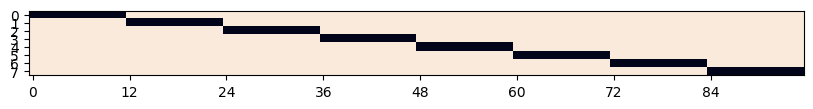

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(codebook, cmap=sns.cm.rocket_r)
plt.xticks(np.arange(0, codebook.shape[1], n_blinks), np.arange(0, codebook.shape[1], n_blinks))
plt.yticks(np.arange(0, codebook.shape[0]), np.arange(0, codebook.shape[0]))
# plt.grid()
plt.show()

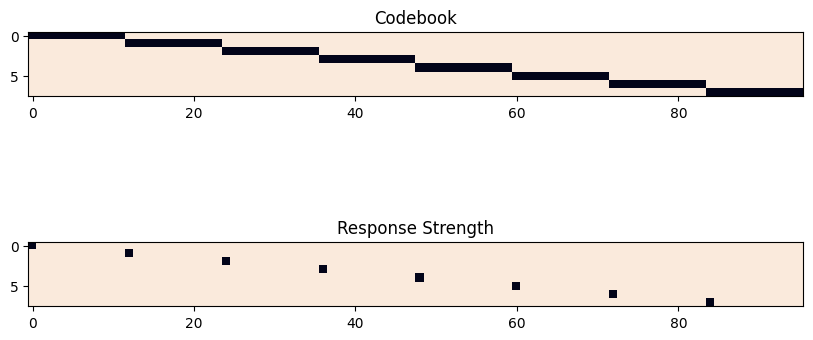

In [5]:
def compute_response(codebook):
    window_high = np.array([0, 0, 0, 0, 0, 1])
    windows = [window_high[i:] for i in range(len(window_high) - 1)][::-1]
    response_strength = np.zeros_like(codebook)
    for window in windows:
        padding = np.zeros((codebook.shape[0], len(window) - 1))
        codebook_padded = np.hstack([padding, codebook])
        for i in range(response_strength.shape[0]):
            for j in range(response_strength.shape[1]):
                if (codebook_padded[i, j:j+len(window)] == window).sum() == len(window):
                    response_strength[i, j] = len(window) + 1
                    
    response_strength = response_strength ** 10
    response_strength = response_strength / response_strength.max()
    
    return response_strength

response_strength = compute_response(codebook)
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].imshow(codebook, cmap=sns.cm.rocket_r)
axs[0].set_title('Codebook')
axs[1].imshow(response_strength, cmap=sns.cm.rocket_r)
axs[1].set_title('Response Strength')
plt.show()

## Codebook 2

In [6]:
n_objs = 8

sfreq = 1000
soa = 250
on_duration = 100
off_duration = 150
switch_duration = 500

n_blinks = 12
n_blinked = 0
n_reps = 1
n_highlights = 3

In [7]:
def gen_row(n_objs: int, prev_rows: np.ndarray, n_highlights: int, n_tries: int=1000) -> np.ndarray:
    # Add a row with minimal horizontal distance
    used_idc = []
    for prev_row in prev_rows:
        used_idc += np.where(prev_row == 1)[0].tolist()
    if len(used_idc) == n_objs:
        return np.ones(n_objs) * 99
    
    idc = np.arange(n_objs)
    idc = np.setdiff1d(idc, used_idc)
    for _ in range(n_tries):
        new_idc = np.sort(np.random.choice(idc, size=n_highlights, replace=False))
        idc_diffs = np.abs(np.diff(new_idc))
        row = np.zeros(n_objs)
        row[new_idc] = 1
        if 1 not in idc_diffs:    
            break
        # if i == n_tries - 1:
        #     print('Warning: couldnt find horizontally spaced row!')
    return row



In [8]:
def gen_codebook(init_codebook: np.ndarray, n_objs, n_obj_highlights, n_off_intervals, n_min_highlights):
    assert n_off_intervals < n_objs // n_obj_highlights
    codebook = init_codebook
    while True:
        if n_off_intervals == 0:
            prev_rows = np.zeros((0, n_objs))
        else:
            prev_rows = codebook[-n_off_intervals:].copy()
        new_row = gen_row(n_objs, prev_rows, n_obj_highlights)
        if 99 not in new_row:
            codebook = np.vstack((codebook, new_row))
        if codebook[init_codebook.shape[0]:].sum(axis=0).min() == n_min_highlights:
            break
        
    codebook = codebook[1:]
    codebook = [i for i in codebook.tolist() if i != [2] * n_objs]
    codebook = np.array(codebook)
    return codebook

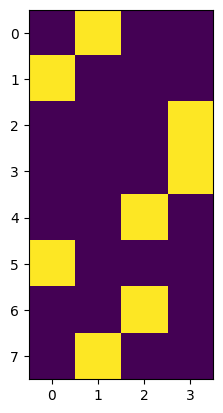

In [9]:
init_codebook = np.zeros((1, n_objs))
codebook = gen_codebook(
    init_codebook = init_codebook,
    n_objs=8, n_obj_highlights=2, n_off_intervals=3, n_min_highlights=1
)
plt.imshow(codebook.T)
plt.show()

<Axes: >

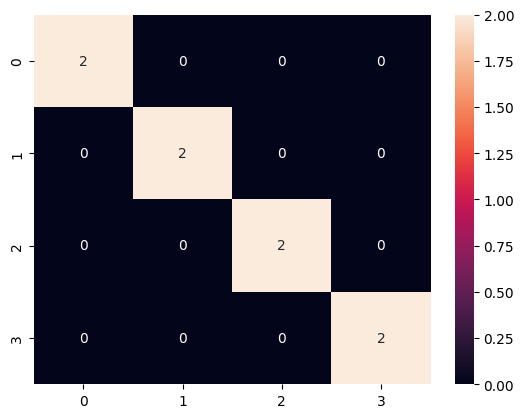

In [10]:
def compute_hamming_distance(codebook: np.ndarray) -> np.ndarray:
    codebook = codebook.copy()
    n_objs = codebook.shape[0]
    
    diffs = np.zeros((n_objs, n_objs))

    for i in range(n_objs):
        for j in range(n_objs):
            seq1 = codebook[i]
            seq1[seq1 == 0] = np.nan
            seq2 = codebook[j]
            seq2[seq2 == 0] = np.nan
            
            diffs[i, j] = (seq1 == seq2).sum()
    return diffs

sns.heatmap(compute_hamming_distance(codebook), annot=True)

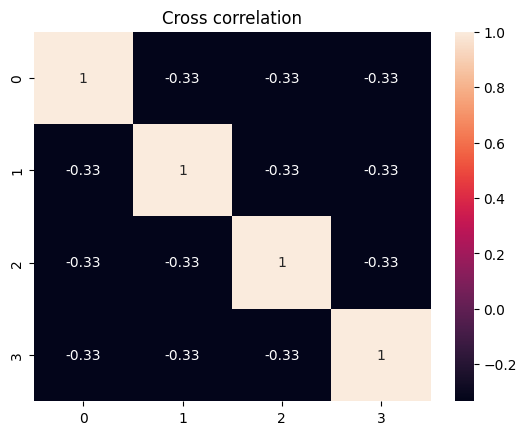

In [16]:
sns.heatmap(np.corrcoef(codebook), annot=True)
plt.title('Cross correlation')
plt.show()

In [18]:
def exist_spatial_neighbors(codebook):
    for i in range(codebook.shape[0]):
        for j in range(codebook.shape[1] - 1):
            if codebook[i, j:j+2].dot(np.array([1, 1])) == 2:
                return True
    return False

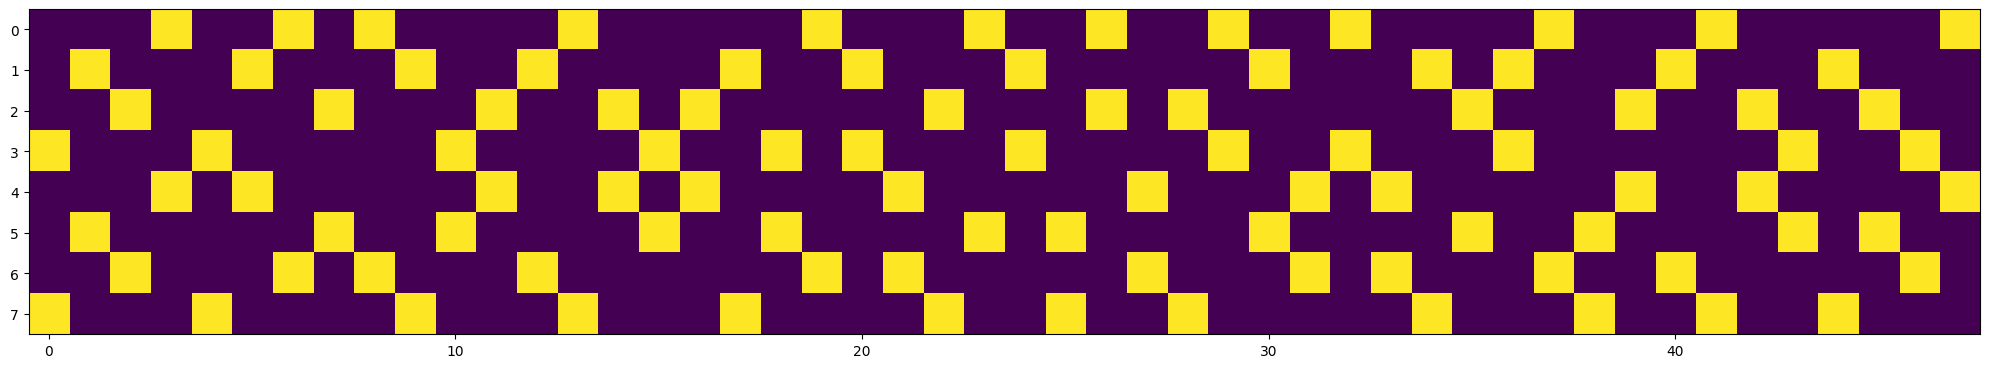

In [19]:
init_codebook = gen_codebook(
    init_codebook = init_codebook,
    n_objs=8, n_obj_highlights=2, n_off_intervals=3, n_min_highlights=1
)

n_reps = 12
codebooks = []
for _ in range(n_reps):
    while True:
        codebook = gen_codebook(
            init_codebook = np.zeros((1, 8)),
            n_objs=8, n_obj_highlights=2, n_off_intervals=3, n_min_highlights=1
        )
        prev_idc = np.where(init_codebook[-1] == 1)[0]
        if codebook[0, prev_idc[0]] == 0 and codebook[0, prev_idc[1]] == 0:
            if not exist_spatial_neighbors(codebook):
                break
        
    codebooks.append(codebook)
    init_codebook = codebook

codebooks = np.vstack(codebooks).T
plt.figure(figsize=(20, 20))
plt.imshow(codebooks)
plt.tight_layout()
# plt.savefig('./rep_1.png', format='png')
plt.show()

<Axes: >

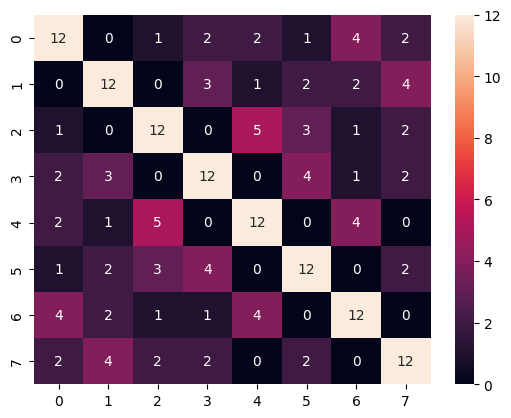

In [20]:
sns.heatmap(compute_hamming_distance(codebooks), annot=True)

<Axes: >

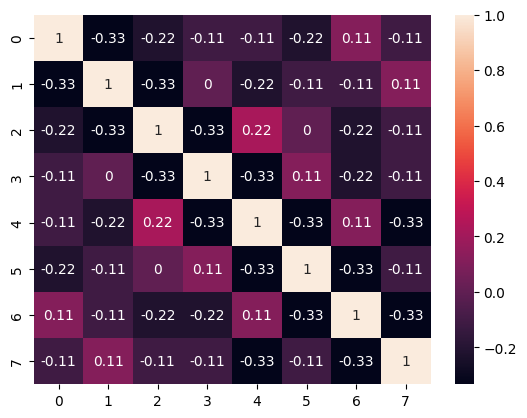

In [22]:
sns.heatmap(np.corrcoef(codebooks), annot=True)

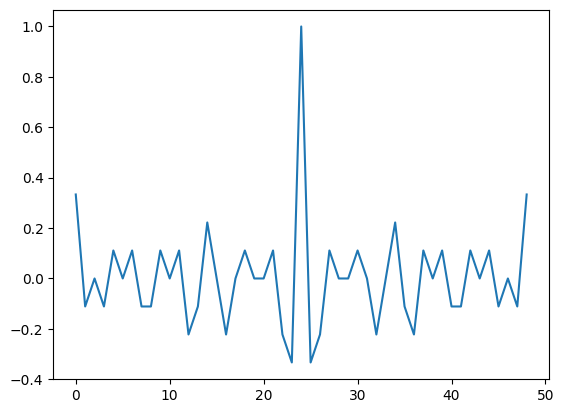

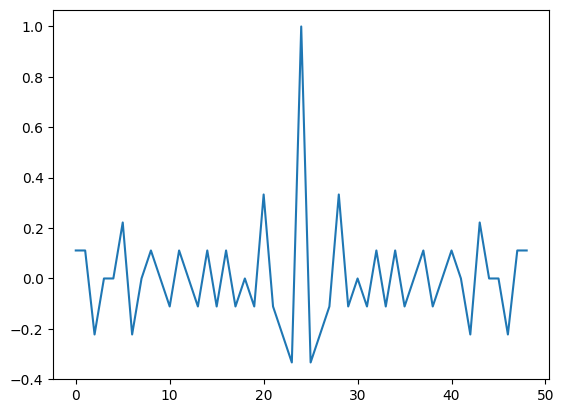

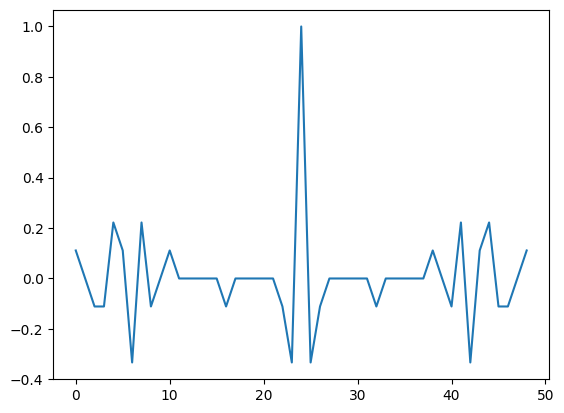

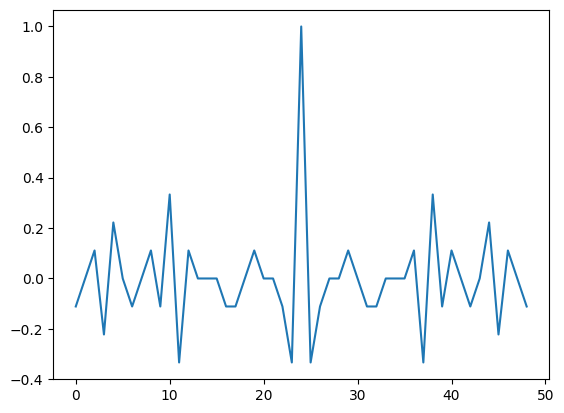

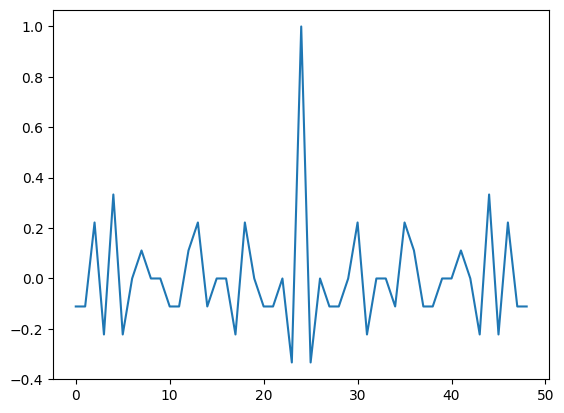

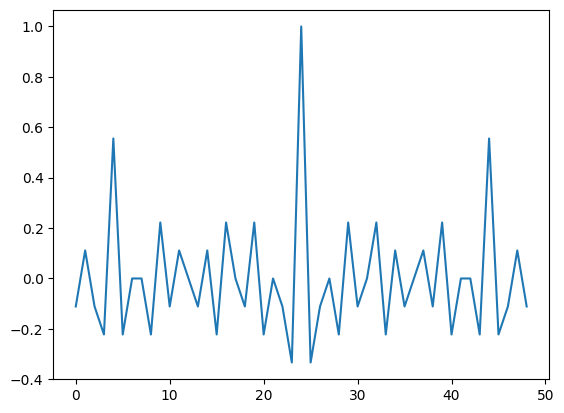

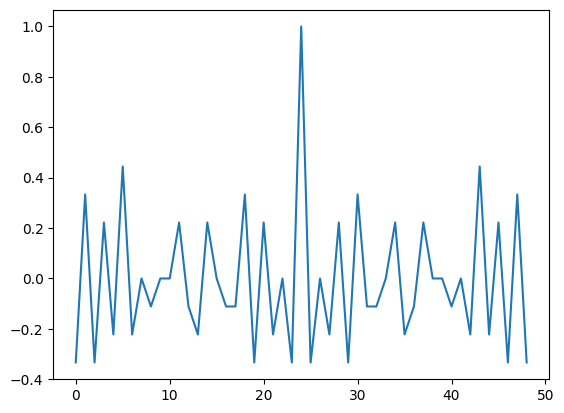

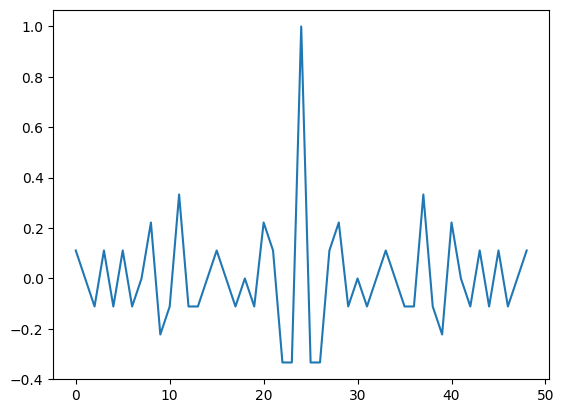

In [23]:
for obj in range(n_objs):
    corrs = []
    for i in range(-24, 25):
        corrs.append(np.corrcoef(codebooks[obj], np.roll(codebooks[obj], i))[0, 1])
    plt.plot(corrs)
    plt.show()

In [26]:
codebook.shape

(4, 8)